In [1]:
!pip install tensorflow

import os
import nibabel as nib
import numpy as np
import shutil
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import categorical_crossentropy


Download data from Kaggle

In [2]:
# Configure Kaggle API key
from google.colab import files
files.upload() # Upload kaggle.json API key

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d awsaf49/brats20-dataset-training-validation
!unzip brats20-dataset-training-validation.zip -d /content/brats2020

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
 99% 4.14G/4.16G [00:37<00:00, 276MB/s]
100% 4.16G/4.16G [00:37<00:00, 118MB/s]
Archive:  brats20-dataset-training-validation.zip
  inflating: /content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: /content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: /content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: /content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: /content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
  inflating: /content/brats2020/BraTS2020

**Data Preprocessing**

In [3]:
def preprocessing(image, seg):
    """
    Preprocess an MRI image or segmentation mask by cropping to the central
    128x128x128 region.
    Normalises MRI images and converts segmentation masks to one-hot encoded labels.

    Args:
        image (nibabel.Nifti1Image): .nii image file
        seg (bool):
            - If False, the input is an MRI image. It will be cropped and min-max normalized.
            - If True, the input is a segmentation mask. It will be cropped and converted to one-hot encoded labels

    Returns:
        np.ndarray or tf.Tensor:
            - A 128x128x128x1 NumPy array if `seg` is False (normalised MRI image).
            - A 128x128x128x4 TensorFlow tensor if `seg` is True (one-hot encoded segmentation mask).
    """

    image_data = image.get_fdata()

    height, width, depth = image_data.shape # Original size (240, 240, 155)

    # Calculate the center of the image
    center_x, center_y = width // 2, height // 2

    # Calculate the starting and ending indices for the crop
    start_x = center_x - 128 // 2
    end_x = start_x + 128

    start_y = center_y - 128 // 2
    end_y = start_y + 128

    start_z = 26 # First 25 slices often blank
    end_z = start_z + 128

    # Crop the middle 128x128 (x, y) section from the selected slice. Final 128 slices chosen from 26:154.
    cropped_image_data = image_data[start_x:end_x, start_y:end_y, start_z:end_z]

    if seg is False: # MRI image
        # Min-max normalising using local minimum and maximum.
        cropped_image_data = (cropped_image_data - cropped_image_data.min()) / (cropped_image_data.max() - cropped_image_data.min())
        cropped_image_data = cropped_image_data[..., np.newaxis] # Add channel = 1
    else: # Ground truth, segmented image
        cropped_image_data[cropped_image_data == 4] = 3
        cropped_image_data = tf.one_hot(cropped_image_data, depth=4)

    return cropped_image_data

**Data Loading**

In [4]:
def load_data(data_path, output_path):
    """
    Loads, preprocesses, and saves MRI and segmentation as .npy from the BraTS2020 dataset.

    Args:
        data_path (str): Path to the root directory of the BraTS2020 training data.
        output_path (str): Path to the directory where processed `.npy` files will be saved.
    """

    # File with wrong name
    old_name = '/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii'
    new_name = '/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'

    # Rename file with the wrong name
    try:
        os.rename(old_name, new_name)
        print("File has been re-named successfully!")
    except:
        print("File is already renamed!")

    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        if os.path.isdir(folder_path):
            output_folder = os.path.join(output_path, folder)

            # Remove the output folder if it exists and recreate it once per folder
            if os.path.exists(output_folder):
                shutil.rmtree(output_folder)
            os.makedirs(output_folder)

            for file in os.listdir(folder_path):
                if file.endswith('.nii'):
                    file_path = os.path.join(folder_path, file)

                    image = nib.load(file_path)

                    new_file_name = file
                    output_file_path = os.path.join(output_folder, new_file_name)
                    output_file_path = output_file_path.replace('.nii', "")

                    if 'seg' in file:
                        # Convert segmentation to one-hot encoding
                        preprocessed_image = preprocessing(image, True)
                    else:
                        preprocessed_image = preprocessing(image, False)

                    np.save(output_file_path, preprocessed_image)

                    # Delete the original .nii file to save space
                    os.remove(file_path)

            print(f'Processed: {folder}')

In [ ]:
    training_data = '/content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    processed_data = '/content/brats2020/Processed_Data'

    # Generate processed data
    load_data(training_data, processed_data)

File has been re-named successfully!
Processed: BraTS20_Training_301
Processed: BraTS20_Training_052
Processed: BraTS20_Training_284
Processed: BraTS20_Training_053
Processed: BraTS20_Training_315
Processed: BraTS20_Training_252
Processed: BraTS20_Training_195
Processed: BraTS20_Training_091
Processed: BraTS20_Training_353
Processed: BraTS20_Training_056
Processed: BraTS20_Training_173
Processed: BraTS20_Training_323
Processed: BraTS20_Training_240
Processed: BraTS20_Training_088
Processed: BraTS20_Training_152
Processed: BraTS20_Training_201
Processed: BraTS20_Training_202
Processed: BraTS20_Training_321
Processed: BraTS20_Training_204
Processed: BraTS20_Training_368
Processed: BraTS20_Training_251
Processed: BraTS20_Training_267
Processed: BraTS20_Training_200
Processed: BraTS20_Training_311
Processed: BraTS20_Training_340
Processed: BraTS20_Training_226
Processed: BraTS20_Training_245
Processed: BraTS20_Training_067
Processed: BraTS20_Training_123
Processed: BraTS20_Training_281
Pro

**Data Splitting**

In [ ]:
def split_data(data_path):
    """
    Splits the dataset directories into training, validation, and test sets.

    Args:
        data_path (str): Path to the root directory containing preprocessed data.

    Returns:
        tuple: A tuple of three lists:
            - train_paths (list of str): Paths to folders used for training (68% of total data).
            - val_paths (list of str): Paths to folders used for validation (20% of total data).
            - test_paths (list of str): Paths to folders used for testing (12% of total data).
    """
    all_directories = []

    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        if os.path.isdir(folder_path):
            all_directories.append(folder_path)


    # Split into train+test and validation sets. 80% train_test, 20% validation.
    train_test_paths, val_paths = train_test_split(all_directories, test_size=0.2, random_state=42)

    # Split the train+test set into train and test sets. 68% training, 12% testing.
    train_paths, test_paths = train_test_split(train_test_paths, test_size=0.15, random_state=42)

    print(f"Number of training IDs: {len(train_paths)}")
    print(f"Number of validation IDs: {len(val_paths)}")
    print(f"Number of test IDs: {len(test_paths)}")

    return train_paths, val_paths, test_paths

**Data Generator**

In [ ]:
def data_generator(data_path, batch_size):
    """
    A generator that yields batches of preprocessed MRI FLAIR images and their corresponding segmentation masks.

    Args:
        data_path (list of str): A list of folder paths, where each folder contains preprocessed `.npy` files for
                                 a single patient.
        batch_size (int): Number of samples to include in each batch.

    Yields:
        tuple: A tuple containing:
            - images (np.ndarray): A NumPy array of shape (batch_size, 128, 128, 128, 1), containing input FLAIR volumes.
            - masks (np.ndarray): A NumPy array of shape (batch_size, 128, 128, 128, 4), containing one-hot encoded segmentation masks.
    """
    while True:
        np.random.shuffle(data_path)  # Shuffle cases at the start of each epoch

        # Iterate through the data in batches
        for batch_start in range(0, len(data_path), batch_size):
            image_batch = []
            seg_batch = []

            # Handle the last batch with fewer samples
            batch_end = min(batch_start + batch_size, len(data_path))
            current_batch_paths = data_path[batch_start:batch_end]

            for folder_path in current_batch_paths:
                # Image and segmentation file paths
                flair_path = os.path.join(folder_path, f"{os.path.basename(folder_path)}_flair.npy")
                seg_path = os.path.join(folder_path, f"{os.path.basename(folder_path)}_seg.npy")

                # Load and append to batch
                image_batch.append(np.load(flair_path))
                seg_batch.append(np.load(seg_path))

            # Convert lists to numpy arrays and yield
            yield np.array(image_batch), np.array(seg_batch)

**Unet Model**

In [ ]:
"""
    Generated using GPT
"""
def unet(input_shape=(128, 128, 128, 1), num_classes=4, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv3D(16, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv3D(16, 3, activation='relu', padding='same')(conv1)
    dropout1 = layers.Dropout(dropout_rate)(conv1)  # Dropout layer
    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(dropout1)

    conv2 = layers.Conv3D(32, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv3D(32, 3, activation='relu', padding='same')(conv2)
    dropout2 = layers.Dropout(dropout_rate)(conv2)  # Dropout layer
    pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(dropout2)

    conv3 = layers.Conv3D(64, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv3D(64, 3, activation='relu', padding='same')(conv3)
    dropout3 = layers.Dropout(dropout_rate)(conv3)  # Dropout layer
    pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(dropout3)

    conv4 = layers.Conv3D(128, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv3D(128, 3, activation='relu', padding='same')(conv4)
    dropout4 = layers.Dropout(dropout_rate)(conv4)  # Dropout layer

    # Decoder
    up5 = layers.Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(dropout4)
    concat5 = layers.concatenate([up5, dropout3])
    conv5 = layers.Conv3D(64, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.Conv3D(64, 3, activation='relu', padding='same')(conv5)
    dropout5 = layers.Dropout(dropout_rate)(conv5)  # Dropout layer

    up6 = layers.Conv3DTranspose(32, 2, strides=(2, 2, 2), padding='same')(dropout5)
    concat6 = layers.concatenate([up6, dropout2])
    conv6 = layers.Conv3D(32, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv3D(32, 3, activation='relu', padding='same')(conv6)
    dropout6 = layers.Dropout(dropout_rate)(conv6)  # Dropout layer

    up7 = layers.Conv3DTranspose(16, 2, strides=(2, 2, 2), padding='same')(dropout6)
    concat7 = layers.concatenate([up7, dropout1])
    conv7 = layers.Conv3D(16, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv3D(16, 3, activation='relu', padding='same')(conv7)
    dropout7 = layers.Dropout(dropout_rate)(conv7)  # Dropout layer

    outputs = layers.Conv3D(num_classes, 1, activation='softmax')(dropout7)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model


Compute class weights to manage class imbalance

In [ ]:
"""
Class weight calculated using: class_weight_i = total_pixels / (num_classes * class_frequencies_i)
"""

processed_data = '/content/brats2020/Processed_Data'

# Define class labels
class_labels = [0, 1, 2, 3]
num_classes = len(class_labels)

# Initialize accumulators
class_frequencies = np.zeros(num_classes)
total_pixels = 0

# Iterate over all segmentation files
for folder in os.listdir(processed_data):
    folder_path = os.path.join(processed_data, folder)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('_seg.npy'):
            file_path = os.path.join(folder_path, file_name)

            # Load the segmentation data
            segmentation = np.load(file_path)
            segmentation = np.argmax(segmentation, axis=-1)

            # Flatten segmentation to get a 1D array of labels
            flat_segmentation = segmentation.flatten()

            # Count frequencies for each class present in the file
            unique, counts = np.unique(flat_segmentation, return_counts=True)
            for u, c in zip(unique, counts):
                class_frequencies[u] += c
            total_pixels += flat_segmentation.size

# Compute class weights based on frequencies
class_weights = np.zeros(num_classes)
for label in class_labels:
    if class_frequencies[label] > 0:
        class_weights[label] = total_pixels / (num_classes * class_frequencies[label])

print(class_weights)


Weighted Dice Loss Function

In [ ]:
"""
  Generated using GPT
"""

def weighted_dice_loss(weights, smooth=1e-6):
    """
    Returns a weighted Dice loss function.
    Dice loss measures the overlap between predicted and true segmentations.

    Args:
        weights (np.array): An array of class weights, where weights[i] is the weight for class i.
        smooth (float): A small constant to avoid division by zero.

    Returns:
        A loss function that takes (y_true, y_pred) and returns the weighted Dice loss.
    """
    # Convert weights to tensor
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Flatten prediction and ground truth, preserve class channels.
        y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

        intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
        denom = tf.reduce_sum(y_true_f + y_pred_f, axis=0)

        dice_score = (2. * intersection + smooth) / (denom + smooth)
        weighted_dice = weights * (1 - dice_score) # Apply weights

        return tf.reduce_mean(weighted_dice) # Return mean dice scores across classes

    return loss

Weighted Categorical Cross Entropy Function

In [ ]:
"""
  Generated using GPT
"""
def weighted_categorical_crossentropy(weights):
    """
    Returns a weighted categorical crossentropy loss function.
    Categorical cross entropy measures the difference in predicted probabilities of classes with the true label.

    Args:
        weights (np.array): An array of class weights, where weights[i] is the weight for class i.

    Returns:
        A loss function that can be used in model.compile.
    """
    def loss(y_true, y_pred):
        # Categorical cross entropy loss for each pixel
        cce = categorical_crossentropy(y_true, y_pred)

        weights_vector = tf.reduce_sum(weights * y_true, axis=-1) # Weight for true class for each pixel
        weighted_loss = cce * weights_vector # Apply weights to cce loss

        return tf.reduce_mean(weighted_loss) # Return mean loss across all pixels in the batch.
    return loss

Dice score metrics

In [ ]:
"""
  Generated using GPT
"""
def dice_score_per_class(class_index, smooth=1e-6):
    """
    Returns a dice score for a specific class index.
    Dice score measures the overlap between the predicted segmentation and the ground truth.

    Args:
        class_index (int): The index of the class.
        smooth (float): A small constant to avoid division by 0.

    Returns:
        function: A function that takes (y_true, y_pred) as inputs and returns the Dice score for the specified class.
    """
    def dice(y_true, y_pred):
        # Extract only the target class
        y_true_c = y_true[..., class_index]
        y_pred_c = y_pred[..., class_index]

        # Flatten 3D volume to 1D array.
        y_true_f = K.flatten(y_true_c)
        y_pred_f = K.flatten(y_pred_c)

        intersection = K.sum(y_true_f * y_pred_f) # Calculate intersection between prediction and ground truth
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth) # Calculate dice score

    return dice

# Create dice score metrics for each class
dice_score_background = dice_score_per_class(0)
dice_score_background.__name__ = 'dice_background'

dice_score_necrotic = dice_score_per_class(1)
dice_score_necrotic.__name__ = 'dice_necrotic'

dice_score_edema = dice_score_per_class(2)
dice_score_edema.__name__ = 'dice_edema'

dice_score_enhancing = dice_score_per_class(3)
dice_score_enhancing.__name__ = 'dice_enhancing'

**Training the Model**

In [ ]:
model = unet(input_shape=(128, 128, 128, 1), num_classes=4)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=weighted_categorical_crossentropy(class_weights), # Weighted categorical CE loss function
    metrics=['accuracy', dice_score_background, dice_score_necrotic, dice_score_edema, dice_score_enhancing]
)
model.summary()

processed_data = '/content/brats2020/Processed_Data'
train_folders, val_folders, test_folder = split_data(processed_data) # Train, val, test split

batch_size = 4

train_generator = data_generator(train_folders, batch_size) # Train data generator
val_generator = data_generator(val_folders, batch_size) # Validation data generator

# Fit model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_folders) // batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_folders) // batch_size,
)

In [36]:
# Save the model
model.save('/content/unet_model_dropout.keras')

Evaluate on test set and print metrics

In [45]:
# Data generator for test data
test_generator = data_generator(test_folder, batch_size)

# Evaluate model on test data
test_loss, test_acc, dice_bg, dice_necrotic, dice_edema, dice_enhancing = model.evaluate(
    test_generator,
    steps=len(test_folder) // batch_size
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Dice Score - Background: {dice_bg:.4f}")
print(f"Dice Score - Necrotic: {dice_necrotic:.4f}")
print(f"Dice Score - Edema: {dice_edema:.4f}")
print(f"Dice Score - Enhancing: {dice_enhancing:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7189 - dice_background: 0.7901 - dice_edema: 0.0836 - dice_enhancing: 0.0415 - dice_necrotic: 0.0402 - loss: 0.9853

Test Loss: 0.9525
Test Accuracy: 0.7231
Dice Score - Background: 0.7912
Dice Score - Necrotic: 0.0421
Dice Score - Edema: 0.0880
Dice Score - Enhancing: 0.0334


Compare model predictions with ground truth

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


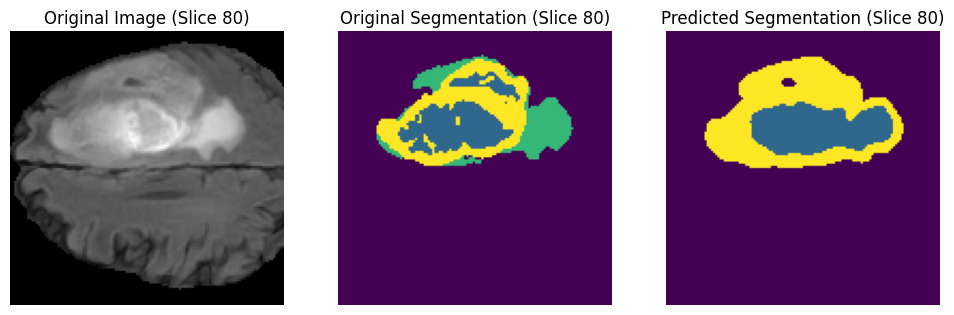

In [ ]:
def plot_predictions(model_save_path, image_idx, slice_idx):
    """
    Loads a trained U-Net model and compares the predicted segmentation with the ground truth and original image.

    Args:
        model_save_path (str): Path to the .keras model file.
        image_idx (int): Index number for the chosen image file.
        slice_idx (int): Index of the slice to visualise.

    Returns:
        None. Displays a matplotlib figure with three subplots: the input image, ground truth, and predicted segmentation.
    """
    # Load the model with the created metrics
    model = load_model(model_save_path, custom_objects={
        'loss': weighted_categorical_crossentropy(class_weights),
        'dice_background': dice_score_background,
        'dice_necrotic': dice_score_necrotic,
        'dice_edema': dice_score_edema,
        'dice_enhancing': dice_score_enhancing})

    # Load the preprocessed image and segmentation mask
    image_path = f'/content/brats2020/Processed_Data/BraTS20_Training_{image_idx}/BraTS20_Training_{image_idx}_flair.npy'
    seg_path = f'/content/brats2020/Processed_Data/BraTS20_Training_{image_idx}/BraTS20_Training_{image_idx}_seg.npy'

    image = np.load(image_path)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = np.expand_dims(image, axis=-1)  # Add channel dimension

    original_seg = np.load(seg_path)
    original_seg = np.argmax(original_seg, axis=-1)  # Convert from one-hot encoding to labels

    # Predict the segmentation
    prediction = model.predict(image)

    # Get the predicted segmentation labels
    predicted_segmentation = np.argmax(prediction, axis=-1)  # Shape will be (1, 128, 128, 128)

    # Remove the batch dimension
    predicted_segmentation = np.squeeze(predicted_segmentation)

    """
        Plot created using GPT
    """
    plt.figure(figsize=(12, 6))

    # Plot the original image slice
    plt.subplot(1, 3, 1)
    plt.imshow(image[0, :, :, slice_idx, 0], cmap='gray')
    plt.title(f"Original Image (Slice {slice_idx})")
    plt.axis('off')

    # Plot the original segmentation slice
    plt.subplot(1, 3, 2)
    plt.imshow(original_seg[:, :, slice_idx])
    plt.title(f"Original Segmentation (Slice {slice_idx})")
    plt.axis('off')

    # Plot the predicted segmentation slice
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_segmentation[:, :, slice_idx])
    plt.title(f"Predicted Segmentation (Slice {slice_idx})")
    plt.axis('off')

    plt.show()


plot_predictions('/content/unet_model_dropout.keras', 355, 80)